<a href="https://colab.research.google.com/github/jhihan/Value_at_Risk_Python/blob/master/VaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install arch

     |████████████████████████████████| 716kB 2.8MB/s 


In [0]:
# example of ARCH model
import numpy as np
from random import gauss
from random import seed
from matplotlib import pyplot
from arch import arch_model
import pandas as pd
from scipy.stats import binom

Read and preprocess the data such as calculating the continously compounded return.

In [0]:
# here we use the USD YEN exchange rate as an example
# Data is downloaded from https://www.macrotrends.net/2550/dollar-yen-exchange-rate-historical-chart
data = pd.read_csv("dollar-yen-exchange-rate-historical-chart.csv", header = 8) 

In [4]:
data.tail()

,date,value
12385,2019-10-26,108.6650
12386,2019-10-28,108.9695
12387,2019-10-29,108.8665
12388,2019-10-30,108.8185
12389,2019-10-31,108.1675


In [5]:
# preprocessing the data
df=data[(data['date'] >= '2009-10-31') & (data['date'] <= '2019-10-31')]
df.rename(columns={' value':'value'}, inplace=True)
df['return']=df.value.pct_change()
# define a new list which ignore the first (index 0) NAN value
return_list=df['return'].tolist()[1:]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


GARCH(1,1) model is used to determined the volatility.

In [6]:
# Using GARCH(1,1) to determine the volatility
model = arch_model(return_list, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit()
volatility = model_fit.conditional_volatility
print(model_fit.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: -10085.986032212
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10085.986035013902
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                10086.0
Distribution:                  Normal   AIC:                          -20166.0
Method:            Maximum Likelihood   BIC:                          -20148.3
                                        No. Observations:                 2646
Date:                Fri, Nov 01 2019   Df Residuals:                     2643
Time:                        08:55:04   Df Model:                            3


/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.25e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Estimate the Volatility in the next date with the GARCH(1,1) model

In [7]:
# Estimate the volatility in the next date
omega = model_fit.params['omega'] 
alpha = model_fit.params['alpha[1]']
beta = model_fit.params['beta[1]']
vola_estimate = omega + alpha * np.power(return_list[-1] , 2)  + beta * np.power( volatility[-1] , 2 )
vola_estimate = np.sqrt(vola_estimate)
print('The volatility in the next date=', vola_estimate )
#return_scienarios = []
#for i in range(0,return_list)

vola= 0.0038338334199308896


Value at Risk Calculation: historical simulation with volatility updating

In [0]:
# calculate the predicted value in the next date under different scenario and inporporate volatility updating
Market_scienarios = []
N_history = len(return_list)
Value_current = df.loc[df.index[-1], 'value']
df.loc[df.index[-1], 'value']
for i in range(0, N_history ):
  Market_value = Value_current *  ( 1 + return_list[i] * vola_estimate/volatility[i] )
  Market_scienarios.append(Market_value)

In [11]:
# Value at Risk (VaR) determination
# CL_Var: condifence level for VaR
CL_VaR = 95
Value_current = df.loc[df.index[-1], 'value']
Value_at_Risk = np.percentile(Market_scienarios,100-CL_VaR) -  Value_current
print("The 1 day", CL_VaR,"% VaR:", -Value_at_Risk)

The 1 day 95 % VaR: 0.64802029956887


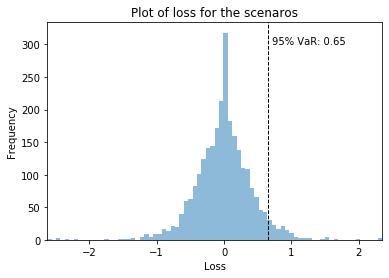

In [24]:
# Make the histogram of loss for the scenaros considered between current date and the next date
import matplotlib.pyplot as plt
mss = np.asarray(Value_current - Market_scienarios )

plt.xlim([min(mss), max(mss)])

plt.hist(mss, bins='auto', alpha=0.5)
plt.title('Plot of loss for the scenaros')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.axvline( -Value_at_Risk , color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(-Value_at_Risk*1.1, max_ylim*0.9, '{}% VaR: {:.2f}'.format(CL_VaR ,-Value_at_Risk))
plt.show()

Value-at-Risk backtesting:
here the binomial one-tailed test is used

In [26]:
# Confidence level for backtesting
CL_backtesting = 95
# The probability of the VaR beeing exceeded on given day
p = 1 - CL_VaR/100
N_confidence = binom.ppf( CL_backtesting*0.01, N_history, p)
N_exceeded = sum( v < Value_at_Risk + Value_current for v in Market_scienarios)

print("We look at total", N_history,"days. VaR level is reached at", N_exceeded , "days.")
if N_exceeded <= N_confidence:
  print ("This VaR model is accepted at", CL_backtesting,"% confidence level.")
else:
  print ("This VaR model is rejected at", CL_backtesting,"% confidence level.")

We look at total 2646 days. VaR level is reached at 133 days.
This VaR model is accepted at 95 % confidence level.
